In [1]:
import gsw, time, datetime, sys, os, glob, xgcm, matplotlib, xarray as xr, numpy as np, dask.array as da, pandas as pd, cartopy.crs as ccrs
import matplotlib.patches as patches, cmocean
from scipy import signal, fft
import xrft
import cartopy.mpl.ticker as cticker, string
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm, TwoSlopeNorm
import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates

In [2]:
file = "/media/fcampos/DATA_SAVE/data_fernando/kuroshio_regions_winter/surface_currents_COAS_winter_region_A.nc"
dc = xr.open_mfdataset(file, parallel=True,).transpose("longitude", "latitude", "time")

file = "/media/fcampos/DATA_SAVE/data_fernando/kuroshio_regions_winter/surface_currents_Ocean-forced_winter_region_A.nc"
du = xr.open_mfdataset(file, parallel=True,).transpose("longitude", "latitude", "time")

/home/fcampos/miniconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'argo' loading failed:
cannot import name 'resolve_auth_type' from 'botocore.auth' (/home/fcampos/miniconda3/lib/python3.11/site-packages/botocore/auth.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
def calc_ispec_3d(k,l,E):
    dk = np.abs(k[2]-k[1])
    dl = np.abs(l[2]-l[1])
    #k, l = np.meshgrid(k,l)
    wv = np.sqrt(k[:,None]**2+l[None,:]**2)
    kmax = min(k.max(), l.max())
    nl, nk, nomg = E.shape
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr/2.,dkr)
    Er = np.zeros((kr.size,nomg))
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
        dth = np.pi / (fkr.sum()-1)
        Er[i,:] = (E*wv[:,:,None]*fkr[:,:,None]*dth).sum(axis=(0,1))
    return kr, Er.squeeze()

def computing_KE_spectrum(u, v, dx, dy, dt):
    print("1) detrending ...")
    nx, ny, nt = u.shape
    kx, ky, kt = fft.fftfreq(nx,dx), fft.fftfreq(ny,dy), fft.rfftfreq(nt,dt)
    dkx, dky, dkt = 1/(dx*nx), 1/(dy*ny), 1/(dt*nt)
    u = signal.detrend(u, axis=2,type="linear")
    v = signal.detrend(v, axis=2,type="linear")
    u = signal.detrend(u, axis=0,type="linear")
    u = signal.detrend(u, axis=1,type="linear")    
    v = signal.detrend(v, axis=0,type="linear")
    v = signal.detrend(v, axis=1,type="linear")
    print("2) windowing ...")
    win1, win2, win3 =  np.hanning(nx), np.hanning(ny), np.hanning(nt)
    win1, win2, win3 = (nx/(win1**2).sum())*win1, (ny/(win2**2).sum())*win2, (nt/(win3**2).sum())*win3
    win = win1[:,None,None]*win2[None,:,None]*win3[None,None,:]
    u, v = u*win, v*win
    print("3) fft in 3D...")
    fftu, fftv = fft.rfftn(u,axes=(0,1,2)), fft.rfftn(v,axes=(0,1,2))
    ke_spec = 0.5*(fftu.conj()*fftu + fftv.conj()*fftv).real/(dkx*dky*dkt)/(nx*ny*nt)**2
    print("4) computing isotropic spectrum")    
    kr, ke_spec = calc_ispec_3d(fft.fftshift(kx), fft.fftshift(ky), fft.fftshift(ke_spec,axes=(0,1)))    
    return kr, kt, ke_spec

In [4]:
dx, dy, dt = 0.04*111195/1000, 0.04*111195/1000, 1

In [5]:
kr, kt, ke_spec_llc = computing_KE_spectrum(du.U.values,
                                            du.V.values,
                                            dx, dy, dt
                                           )
kr, kt, ke_spec_coas = computing_KE_spectrum(dc.U.values,
                                             dc.V.values,
                                             dx, dy, dt
                                            )

1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum
1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum


In [6]:
Rd = xr.open_dataset("/home/fcampos/Downloads/rossrad.nc").rossby_radius
c = xr.open_dataset("/home/fcampos/Downloads/rossrad.nc").phase_speed
n_mode=5
f0 = (1/12)*np.sin(du.latitude.mean().values*np.pi/180)
mlon, mlat = du.longitude.mean().values, du.latitude.mean().values
Rd0 = Rd.sel(lat=mlat, lon=mlon, method = "nearest").values
Rd0=2*np.pi*Rd0//np.arange(1, n_mode + 1)
c = c.sel(lat=mlat, lon=mlon, method = "nearest").values
omega=np.sqrt(((1+(Rd0[:,None]*kr[None,:])**2)*f0**2))
omega0=c*kr

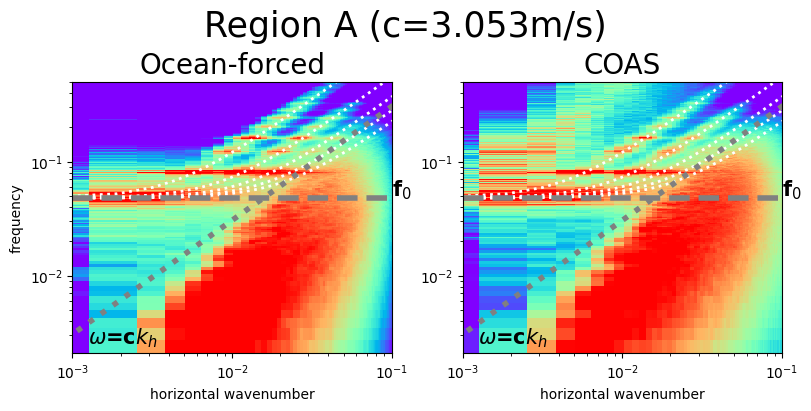

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=2,
                        figsize=(8,4),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)

ax[0].pcolormesh(krr1, ktt1, ke_spec_llc.T*krr1*ktt1,
               norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

ax[1].pcolormesh(krr1, ktt1, ke_spec_coas.T*krr1*ktt1,
               norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

fig.suptitle("Region A (c="+str(c)+"m/s)", fontsize=25)
ax[0].set_title("Ocean-forced", fontsize=20)
ax[1].set_title("COAS", fontsize=20)
ax[0].set_ylabel("frequency", fontsize=10)

for i in range(2):
    ax[i].loglog()
    for j in range(n_mode):
        ax[i].plot(kr,omega[j,:],":", color="white", linewidth=2)
    ax[i].plot(kr,omega0,":",color="gray", linewidth=4)
    ax[i].set_xlim(1e-3,1e-1)
    ax[i].set_ylim(1/(24*20),1/2)
    ax[i].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
    ax[i].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)
    ax[i].text(1/800,1/400, "$\omega$=c$k_{h}$", fontweight="bold", color="black", fontsize=15)
    ax[i].set_xlabel("horizontal wavenumber", fontsize=10)

#plt.savefig("./KE_wk_spectrum_region_a.pdf", dpi=500)                 

In [7]:
import numpy as np
import xarray as xr
from scipy import signal
import numpy.fft as fft

def dynamical_filtering(u, v, dx, dy, dt, lon0, lat0, file, n_mode=10, order=10, c_input=None):
    print("Applying the dynamical filter...")
    
    nx, ny, nt = u.shape
    kx, ky, omega = fft.fftfreq(nx, dx), fft.fftfreq(ny, dy), fft.fftfreq(nt, dt)
    dkx, dky = kx[1] - kx[0], ky[1] - ky[0]
    dkr = np.sqrt(dkx**2 + dky**2)
    kh = np.sqrt(kx[:, None]**2 + ky[None, :]**2)
    kh[kh == kh.min()] = dkr / 2
    
    f0 = (1/12)*np.sin(lat0*np.pi/180)

    # Load Rossby radius and phase speed from file
    ds = xr.open_dataset(file)
    Rd, c = ds["rossby_radius"], ds["phase_speed"]

    # Extract values at the nearest location
    Rd0 = Rd.sel(lat=lat0, lon=lon0, method="nearest").values
    Rd0 = 2 * np.pi * Rd0 / n_mode

    # Use user-supplied c if available, otherwise extract from file
    if c_input is not None:
        c0 = c_input
    else:
        c0 = c.sel(lat=lat0, lon=lon0, method="nearest").values

    # Assume f0 is defined elsewhere or add it as input
    omega0 = np.sqrt((1 + (Rd0 * kh)**2) * f0**2)
    omega1 = c0 * kh

    omega_c = np.fmin(omega0, omega1)

    # Create spectral mask
    mask = 1 / (1 + ((omega[None, None, :] / omega_c[:, :, None])**(2 * order)))

    # Remove linear trend
    u = signal.detrend(u, axis=2, type="linear")
    v = signal.detrend(v, axis=2, type="linear")

    # Apply filter in Fourier domain
    u_bm = fft.ifftn(fft.fftn(u, axes=(0, 1, 2)) * mask, axes=(0, 1, 2)).real
    v_bm = fft.ifftn(fft.fftn(v, axes=(0, 1, 2)) * mask, axes=(0, 1, 2)).real

    return u_bm, v_bm, u - u_bm, v - v_bm


In [8]:
lon0, lat0 = du.longitude.mean().values, du.latitude.mean().values
u_bm_coas, v_bm_coas, u_igw_coas, v_igw_coas = dynamical_filtering(dc.U.values,
                                                                   dc.V.values,
                                                                   dx, dy, dt,
                                                                   lon0, lat0, 
                                                                   "/home/fcampos/Downloads/rossrad.nc", 
                                                                   n_mode=4, order=6, c_input=None
                                                                  )

Applying the dynamical filter...


In [9]:
lon0, lat0 = dc.longitude.mean().values, dc.latitude.mean().values
u_bm_llc, v_bm_llc, u_igw_llc, v_igw_llc = dynamical_filtering(du.U.values,
                                                               du.V.values,
                                                               dx, dy, dt,
                                                               lon0, lat0, 
                                                               "/home/fcampos/Downloads/rossrad.nc", 
                                                               n_mode=4, order=6, c_input=None
                                                              )

Applying the dynamical filter...


In [10]:
kr, kt, ke_spec_BMs_coas = computing_KE_spectrum(u_bm_coas,
                                                 v_bm_coas,
                                                 dx, dy, dt
                                                )
kr, kt, ke_spec_IGWs_coas = computing_KE_spectrum(u_igw_coas,
                                                  v_igw_coas,
                                                  dx, dy, dt
                                                 )

1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum
1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum


In [16]:
# Create an xarray Dataset
ds = xr.Dataset(
    {
        "u_tot": (["longitude", "latitude", "time"], dc.U.values),
        "v_tot": (["longitude", "latitude", "time"], dc.V.values),
        "u_BMs": (["longitude", "latitude", "time"], u_bm_coas),
        "v_BMs": (["longitude", "latitude", "time"], v_bm_coas),
        "u_IGWs": (["longitude", "latitude", "time"], u_igw_coas),
        "v_IGWs": (["longitude", "latitude", "time"], v_igw_coas),
    },
    coords={
        "latitude": dc.latitude,
        "longitude": dc.longitude,
        "time": dc.time
    }
)

ds['u_tot'] = ds['u_tot'].fillna(-32767)
ds['u_tot'].encoding['_FillValue'] = -32767
ds['v_tot'] = ds['v_tot'].fillna(-32767)
ds['v_tot'].encoding['_FillValue'] = -32767

ds['u_BMs'] = ds['u_BMs'].fillna(-32767)
ds['u_BMs'].encoding['_FillValue'] = -32767
ds['v_BMs'] = ds['v_BMs'].fillna(-32767)
ds['v_BMs'].encoding['_FillValue'] = -32767

ds['u_IGWs'] = ds['u_IGWs'].fillna(-32767)
ds['u_IGWs'].encoding['_FillValue'] = -32767
ds['v_IGWs'] = ds['v_IGWs'].fillna(-32767)
ds['v_IGWs'].encoding['_FillValue'] = -32767

# Save the dataset to a NetCDF file (optional)
netcdf_path = "./current_dynamical_filter_coas.nc"
ds.transpose("time", "latitude", "longitude").to_netcdf(netcdf_path)


In [18]:
# Create an xarray Dataset
ds = xr.Dataset(
    {
        "u_tot": (["longitude", "latitude", "time"], du.U.values),
        "v_tot": (["longitude", "latitude", "time"], du.V.values),
        "u_BMs": (["longitude", "latitude", "time"], u_bm_llc),
        "v_BMs": (["longitude", "latitude", "time"], v_bm_llc),
        "u_IGWs": (["longitude", "latitude", "time"], u_igw_llc),
        "v_IGWs": (["longitude", "latitude", "time"], v_igw_llc),
    },
    coords={
        "latitude": dc.latitude,
        "longitude": dc.longitude,
        "time": dc.time
    }
)

ds['u_tot'] = ds['u_tot'].fillna(-32767)
ds['u_tot'].encoding['_FillValue'] = -32767
ds['v_tot'] = ds['v_tot'].fillna(-32767)
ds['v_tot'].encoding['_FillValue'] = -32767

ds['u_BMs'] = ds['u_BMs'].fillna(-32767)
ds['u_BMs'].encoding['_FillValue'] = -32767
ds['v_BMs'] = ds['v_BMs'].fillna(-32767)
ds['v_BMs'].encoding['_FillValue'] = -32767

ds['u_IGWs'] = ds['u_IGWs'].fillna(-32767)
ds['u_IGWs'].encoding['_FillValue'] = -32767
ds['v_IGWs'] = ds['v_IGWs'].fillna(-32767)
ds['v_IGWs'].encoding['_FillValue'] = -32767

# Save the dataset to a NetCDF file (optional)
netcdf_path = "./current_dynamical_filter_ocean_forced.nc"
ds.transpose("time", "latitude", "longitude").to_netcdf(netcdf_path)


In [11]:
kr, kt, ke_spec_BMs_llc = computing_KE_spectrum(u_bm_llc,
                                                v_bm_llc,
                                                dx, dy, dt
                                               )
kr, kt, ke_spec_IGWs_llc = computing_KE_spectrum(u_igw_llc,
                                                 v_igw_llc,
                                                 dx, dy, dt
                                                )

1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum
1) detrending ...
2) windowing ...
3) fft in 3D...
4) computing isotropic spectrum


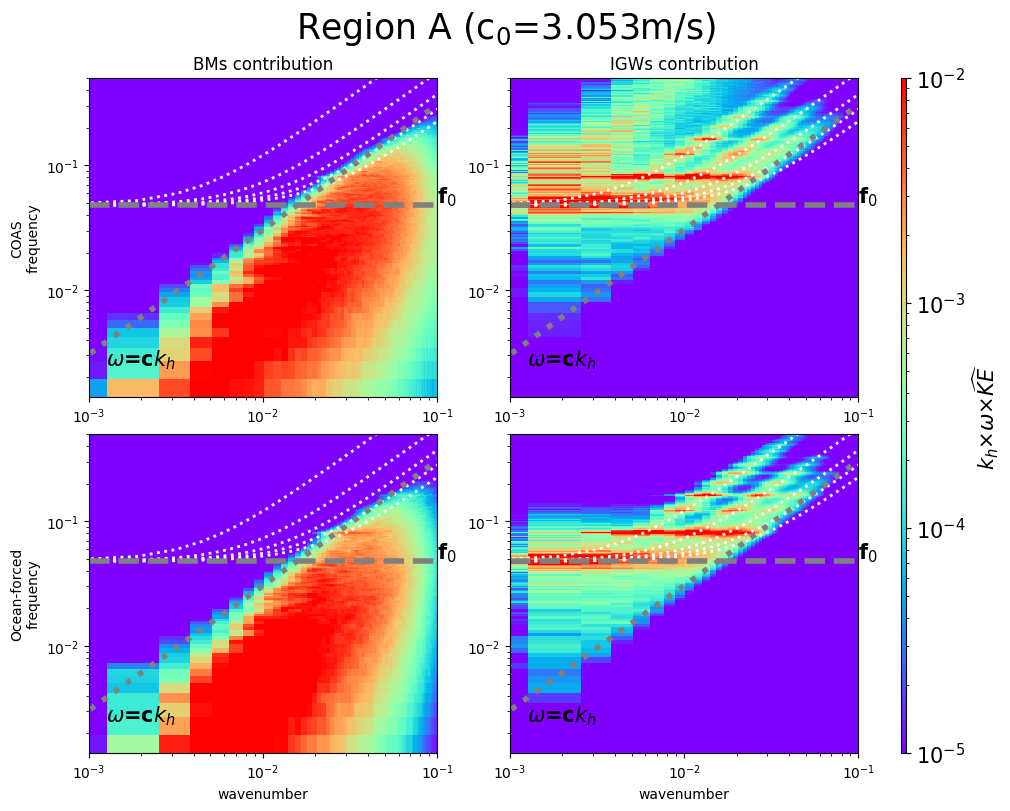

In [13]:
fig, ax = plt.subplots(nrows=2,ncols=2,
                        figsize=(10,8),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)
az00=ax[0,0].pcolormesh(krr1, ktt1, ke_spec_BMs_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az01=ax[0,1].pcolormesh(krr1, ktt1, ke_spec_IGWs_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az10=ax[1,0].pcolormesh(krr1, ktt1, ke_spec_BMs_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az11=ax[1,1].pcolormesh(krr1, ktt1, ke_spec_IGWs_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)
fig.suptitle("Region A (c$_0$="+str(c)+"m/s)", fontsize=25)

ax[0,0].set_ylabel("COAS\nfrequency")
ax[1,0].set_ylabel("Ocean-forced\nfrequency")
ax[1,0].set_xlabel("wavenumber")
ax[1,1].set_xlabel("wavenumber")

ax[0,0].set_title("BMs contribution")
ax[0,1].set_title("IGWs contribution")

cb1 = plt.colorbar(az11, ax=ax, orientation='vertical', pad =0.03, aspect=140, fraction=0.03)       

cb1.ax.tick_params(labelsize=15)
cb1.set_label(label="$k_{h}$" r"$\times \omega$" r"$\times \widehat{KE}$", size=15)

for i in range(2):
    for k in range(2):
        ax[i,k].loglog()
        for j in range(n_mode):
            ax[i,k].plot(kr,omega[j,:],":", color="white", linewidth=2)
        ax[i,k].plot(kr,omega0,":",color="gray", linewidth=4)
        ax[i,k].set_xlim(1e-3,1e-1)
        ax[i,k].set_ylim(1/(24*30),1/2)
        ax[i,k].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
        ax[i,k].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)
        ax[i,k].text(1/800,1/400, "$\omega$=c$k_{h}$", fontweight="bold", color="black", fontsize=15)

plt.savefig("./KE_wk_spectrum_region_dyn_filt_a.pdf", dpi=500)  

In [12]:
def computing_RV_DV_spectrum(u, v, dx, dy, dt):
    print("1) detrending ...")
    nx, ny, nt = u.shape
    kx, ky, kt = fft.fftfreq(nx,dx), fft.fftfreq(ny,dy), fft.rfftfreq(nt,dt)
    dkx, dky, dkt = 1/(dx*nx), 1/(dy*ny), 1/(dt*nt)
    for axis in range(3):
        u = signal.detrend(u, axis=2-axis,type="linear")
        v = signal.detrend(v, axis=2-axis,type="linear")
    
    print("2) windowing ...")
    win1, win2, win3 =  np.hanning(nx), np.hanning(ny), np.hanning(nt)
    win1, win2, win3 = (nx/(win1**2).sum())*win1, (ny/(win2**2).sum())*win2, (nt/(win3**2).sum())*win3
    win = win1[:,None,None]*win2[None,:,None]*win3[None,None,:]
    
    u, v = u*win, v*win
    
    print("3) fft in 3D...")
    fftu, fftv = fft.rfftn(u,axes=(0,1,2)), fft.rfftn(v,axes=(0,1,2))
     
    print("5) computing gradients ...")
    
    k, l, omega = np.meshgrid(kx, ky, kt, indexing='ij')
    i = 1j
        
    fft_divh = i * (k * fftu + l * fftv)
    fft_vort = i * (k * fftv - l * fftu)

    vort_spec = (fft_vort.conj()*fft_vort).real/(dkx*dky*dkt)/(nx*ny*nt)**2
    divh_spec = (fft_divh.conj()*fft_divh).real/(dkx*dky*dkt)/(nx*ny*nt)**2
    wv = np.sqrt(kx[:,None]**2+ky[None,:]**2)
    wv[wv==0] = 0.5*np.sqrt(dkx**2 + dky**2)
    vort_spec=vort_spec/wv[:,:,None]**2
    divh_spec=divh_spec/wv[:,:,None]**2
    kr, vort_spec = calc_ispec_3d(fft.fftshift(kx), fft.fftshift(ky), fft.fftshift(vort_spec,axes=(0,1)))
    kr, divh_spec = calc_ispec_3d(fft.fftshift(kx), fft.fftshift(ky), fft.fftshift(divh_spec,axes=(0,1)))

    return kr, kt, vort_spec/2, divh_spec/2, (vort_spec+divh_spec)/2

In [13]:
kr, kt, RV_spec_llc, DV_spec_llc, RVDV_spec_llc = computing_RV_DV_spectrum(du.U.values,
                                                                           du.V.values,
                                                                           dx, dy, dt
                                                                          )
kr, kt, RV_spec_coas, DV_spec_coas, RVDV_spec_coas = computing_RV_DV_spectrum(dc.U.values,
                                                                              dc.V.values,
                                                                              dx, dy, dt
                                                                             )

1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...
1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...


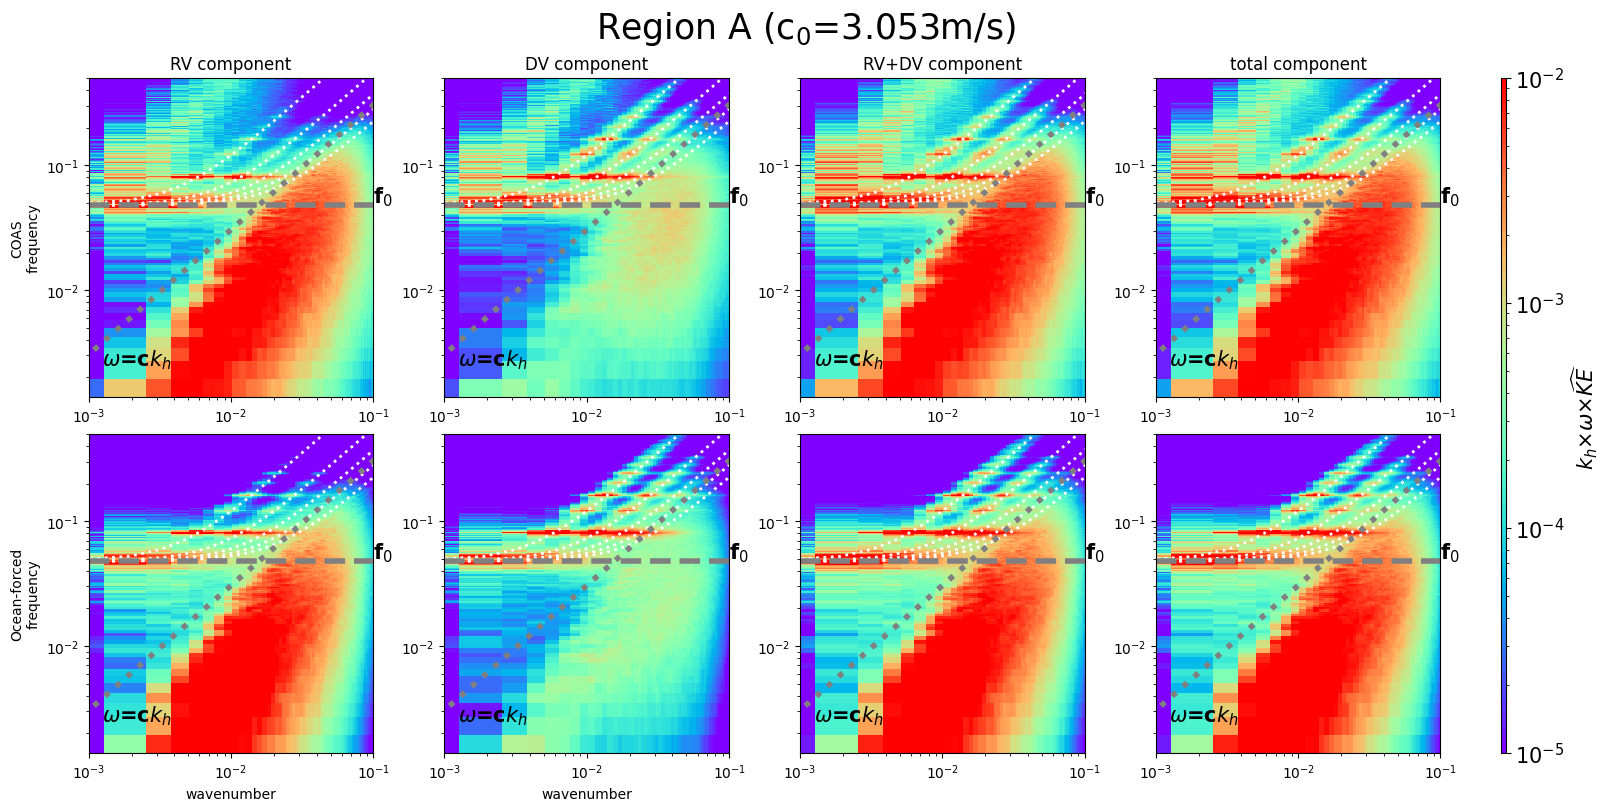

In [18]:
fig, ax = plt.subplots(nrows=2,ncols=4,
                        figsize=(16,8),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)

az00=ax[0,0].pcolormesh(krr1, ktt1, RV_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az01=ax[0,1].pcolormesh(krr1, ktt1, DV_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az02=ax[0,2].pcolormesh(krr1, ktt1, RVDV_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az02=ax[0,3].pcolormesh(krr1, ktt1, ke_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az10=ax[1,0].pcolormesh(krr1, ktt1, RV_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az11=ax[1,1].pcolormesh(krr1, ktt1, DV_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az12=ax[1,2].pcolormesh(krr1, ktt1, RVDV_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

az12=ax[1,3].pcolormesh(krr1, ktt1, ke_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

fig.suptitle("Region A (c$_0$="+str(c)+"m/s)", fontsize=25)

ax[0,0].set_ylabel("COAS\nfrequency")
ax[1,0].set_ylabel("Ocean-forced\nfrequency")
ax[1,0].set_xlabel("wavenumber")
ax[1,1].set_xlabel("wavenumber")

ax[0,0].set_title("RV component")
ax[0,1].set_title("DV component")
ax[0,2].set_title("RV+DV component")
ax[0,3].set_title("total component")

cb1 = plt.colorbar(az11, ax=ax, orientation='vertical', pad =0.03, aspect=140, fraction=0.03)       

cb1.ax.tick_params(labelsize=15)
cb1.set_label(label="$k_{h}$" r"$\times \omega$" r"$\times \widehat{KE}$", size=15)

for i in range(2):
    for k in range(4):
        ax[i,k].loglog()
        for j in range(n_mode):
            ax[i,k].plot(kr,omega[j,:],":", color="white", linewidth=2)
        ax[i,k].plot(kr,omega0,":",color="gray", linewidth=4)
        ax[i,k].set_xlim(1e-3,1e-1)
        ax[i,k].set_ylim(1/(24*30),1/2)
        ax[i,k].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
        ax[i,k].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)
        ax[i,k].text(1/800,1/400, "$\omega$=c$k_{h}$", fontweight="bold", color="black", fontsize=15)

plt.savefig("./KE_wk_spectrum_region_helmholtz_decomposition_a.pdf", dpi=500)  

In [15]:
lon0, lat0 = du.longitude.mean().values, du.latitude.mean().values
u_bm_coas, v_bm_coas, u_igw_coas, v_igw_coas = dynamical_filtering(dc.U.values,
                                                                   dc.V.values,
                                                                   dx, dy, dt,
                                                                   lon0, lat0, 
                                                                   "/home/fcampos/Downloads/rossrad.nc", 
                                                                   n_mode=4, order=6, c_input=None
                                                                  )

lon0, lat0 = dc.longitude.mean().values, dc.latitude.mean().values
u_bm_llc, v_bm_llc, u_igw_llc, v_igw_llc = dynamical_filtering(du.U.values,
                                                               du.V.values,
                                                               dx, dy, dt,
                                                               lon0, lat0, 
                                                               "/home/fcampos/Downloads/rossrad.nc", 
                                                               n_mode=4, order=6, c_input=None
                                                              )

Applying the dynamical filter...
Applying the dynamical filter...


In [16]:
kr, kt, RV_BMs_spec_llc, DV_BMs_spec_llc, RVDV_BMs_spec_llc = computing_RV_DV_spectrum(u_bm_llc,
                                                                                       v_bm_llc,
                                                                                       dx, dy, dt
                                                                                      )
kr, kt, RV_BMs_spec_coas, DV_BMs_spec_coas, RVDV_BMs_spec_coas = computing_RV_DV_spectrum(u_bm_coas,
                                                                                          v_bm_coas,
                                                                                          dx, dy, dt
                                                                                         )

1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...
1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...


In [17]:
kr, kt, RV_IGWs_spec_llc, DV_IGWs_spec_llc, RVDV_IGWs_spec_llc = computing_RV_DV_spectrum(u_igw_llc,
                                                                                       v_igw_llc,
                                                                                       dx, dy, dt
                                                                                      )
kr, kt, RV_IGWs_spec_coas, DV_IGWs_spec_coas, RVDV_IGWs_spec_coas = computing_RV_DV_spectrum(u_igw_coas,
                                                                                          v_igw_coas,
                                                                                          dx, dy, dt
                                                                                         )

1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...
1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...


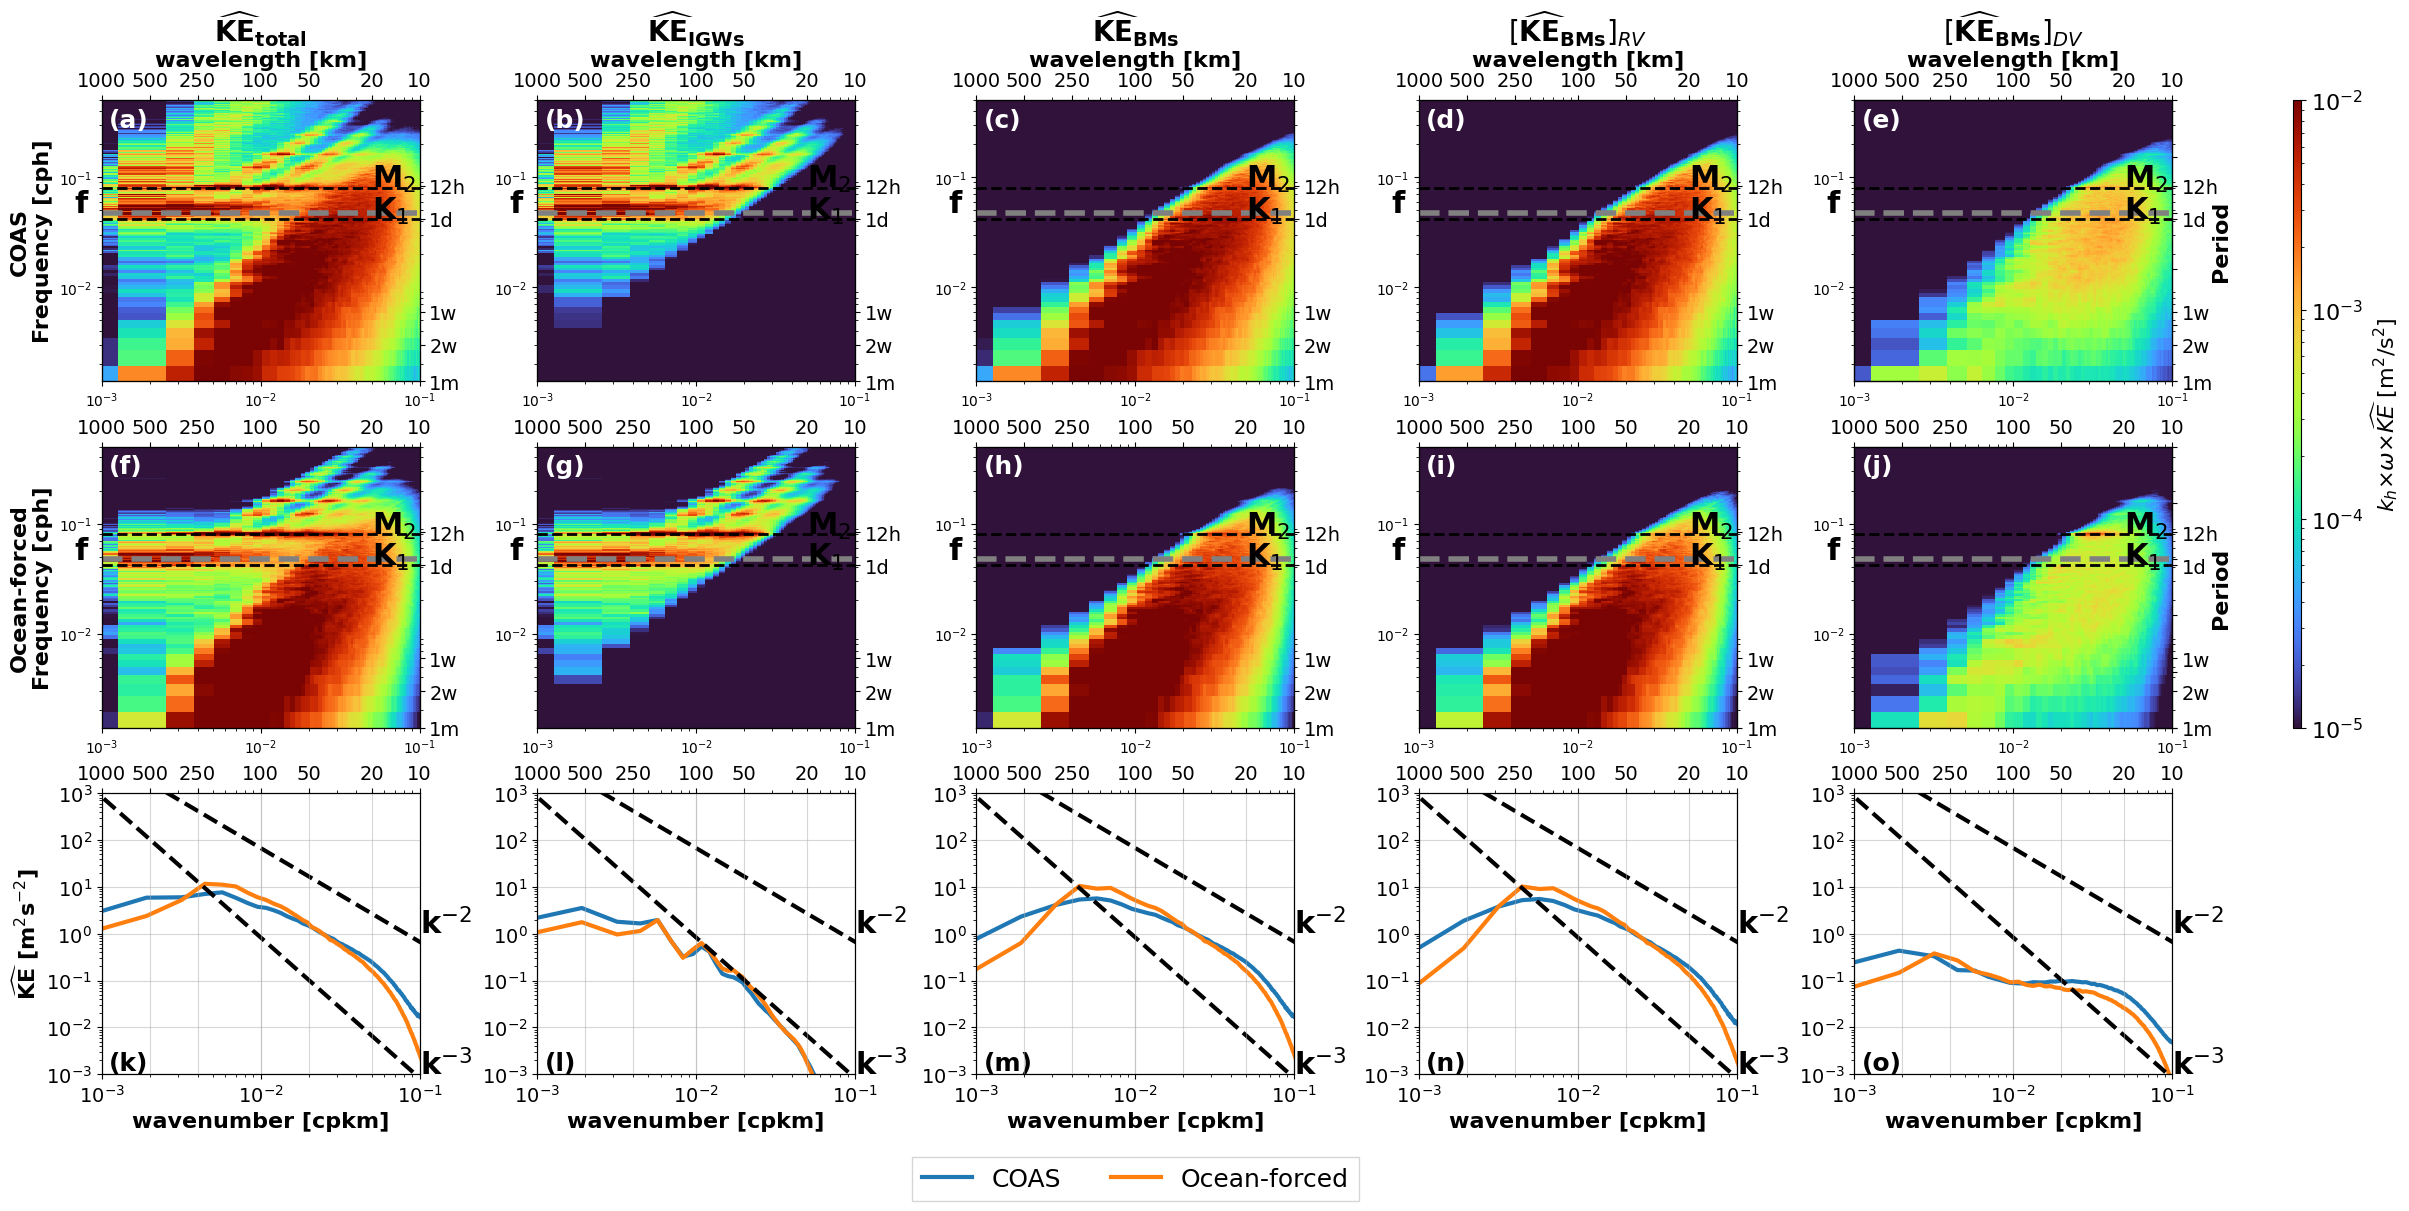

In [39]:
import matplotlib.colors as mcolors

alphabet, num = string.ascii_lowercase, 0

fig, ax = plt.subplots(3,5, figsize=(24,12), constrained_layout=True)

krr, ktt = np.meshgrid(kr, kt)

ke = ke_spec_coas
cmap = "turbo"
az00 = ax[0,0].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,0].plot(kr ,np.trapz(ke, kt, axis=1), color='#1f77b4', linewidth=3, )

ke = ke_spec_llc
az00 = ax[1,0].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,0].plot(kr ,np.trapz(ke, kt, axis=1), color="#ff7f0e", linewidth=3, )

############################################################################################################
ke = ke_spec_IGWs_coas
az00 = ax[0,1].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,1].plot(kr, np.trapz(ke, kt, axis=1), color="#1f77b4", linewidth=3)

ke = ke_spec_IGWs_llc
az01 = ax[1,1].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,1].plot(kr, np.trapz(ke, kt, axis=1), color="#ff7f0e", linewidth=3)

############################################################################################################

ke = ke_spec_BMs_coas
az00 = ax[0,2].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,2].plot(kr, np.trapz(ke, kt, axis=1), color="#1f77b4", linewidth=3, label="COAS")

ke = ke_spec_BMs_llc
az00 = ax[1,2].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,2].plot(kr, np.trapz(ke, kt, axis=1), color="#ff7f0e", linewidth=3, label="Ocean-forced")

############################################################################################################

ke = RV_BMs_spec_coas
az00 = ax[0,3].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,3].plot(kr, np.trapz(ke, kt, axis=1), color="#1f77b4", linewidth=3)

ke = RV_BMs_spec_llc
az00 = ax[1,3].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,3].plot(kr, np.trapz(ke, kt, axis=1), color="#ff7f0e", linewidth=3)

############################################################################################################

ke = DV_BMs_spec_coas
az00 = ax[0,4].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,4].plot(kr, np.trapz(ke, kt, axis=1), color="#1f77b4", linewidth=3)

ke = DV_BMs_spec_llc
az00 = ax[1,4].pcolormesh(krr, ktt, ke.T*krr*ktt,
                                 norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap=cmap, rasterized=True,)
az00 = ax[2,4].plot(kr, np.trapz(ke, kt, axis=1), color="#ff7f0e", linewidth=3)

cb = plt.colorbar(az01, ax=ax[:2,:], orientation='vertical', pad =0.03, aspect=75, fraction=0.02)       
cb.ax.tick_params(labelsize=16)
cb.set_label(label="$k_{h}$" r"$\times \omega$" r"$\times \widehat{KE}$ [m$^2$/s$^2$]", size=16)

ax[0,0].set_ylabel("COAS\nFrequency [cph]", fontweight="bold", size=16)
ax[1,0].set_ylabel("Ocean-forced\nFrequency [cph]", fontweight="bold", size=16)
ax[2,0].set_ylabel("$\mathbf{\widehat{KE}}$ [m$^{2}$s$^{-2}$]", fontweight="bold", size=16)

ax[0,0].set_title("$\mathbf{\widehat{KE}_{total}}$",fontsize=20)
ax[0,1].set_title("$\mathbf{\widehat{KE}_{IGWs}}$",fontsize=20)
ax[0,2].set_title("$\mathbf{\widehat{KE}_{BMs}}$",fontsize=20)

ax[0,3].set_title("[$\mathbf{\widehat{KE}_{BMs}}$]$_{RV}$",fontsize=20)
ax[0,4].set_title("[$\mathbf{\widehat{KE}_{BMs}}$]$_{DV}$",fontsize=20)

ax[2,2].legend(loc='upper center', fontsize=18, ncol=2, fancybox=False, shadow=False, bbox_to_anchor=(0.5, -0.25))


for i in range(5):
    ax[2,i].loglog()
    ax[2,i].set_xlim(1/1000,1/10)
    ax[2,i].set_ylim(1e-3,1e3)
    ax[2,i].tick_params(axis="both", labelsize=16)
    yrec1 = np.exp(-2*np.log(kr)-7+2)
    yrec2 = np.exp(-3*np.log(kr)-16+2)
    ax[2,i].plot(kr,yrec1, '--', linewidth=3, color="black")
    ax[2,i].plot(kr,yrec2, '--', linewidth=3, color="black")
    #ax[2,i].plot([1/18,1/18],[1e-3,1e3],'--', color='black')
    ax1a = ax[2,i].twiny()
    ax1a.grid(alpha=0.5)
    ax[2,i].grid(alpha=0.5)
    ax1a.set_xscale('log')
    ax1a.set_yscale('log')
    ax1a.set_ylim(1e-3,1e3)
    ax1a.set_xlim(1/1000,1/10)
    ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
    ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10'])  
    ax1a.tick_params(axis="both", labelsize=14)
    ax[2,i].tick_params(axis="both", labelsize=14)
    ax[2,i].set_rasterization_zorder(0)
    ax[2,i].set_xlabel("wavenumber [cpkm]", fontweight="bold", size=16)
    ax[2,i].text(1/10,1,"k$^{-2}$",fontweight="bold", size=22)
    ax[2,i].text(1/10,1/1000,"k$^{-3}$",fontweight="bold", size=22)
    ax[0,i].text(1/900,1/3.5, "("+str(alphabet[i])+")", fontweight="bold", color="white", fontsize=18)
    ax[1,i].text(1/900,1/3.5, "("+str(alphabet[i+5])+")", fontweight="bold", color="white", fontsize=18)
    ax[2,i].text(1/900,1/830, "("+str(alphabet[i+10])+")", fontweight="bold", color="black", fontsize=18)

ax1b = ax[0,4].twinx()
ax1b.set_ylabel("\nPeriod", fontweight="bold", size=16)
ax1b.set_yticklabels([])  # Eliminar los números del eje Y
ax1b = ax[1,4].twinx()
ax1b.set_ylabel("\nPeriod", fontweight="bold", size=16)
ax1b.set_yticklabels([])  # Eliminar los números del eje Y

for i in range(5):
    for j in range(2):        
        ax[j,i].set_xlim(1/1000,1/10)
        ax[j,i].set_ylim(1/(24*30),1/2)        
        ax1a = ax[j,i].twiny()
        ax1b = ax[j,i].twinx()
        ax1a.set_xlim(1e-3,1e-1)
        ax1a.set_ylim(1/(24*30),1/2)
        ax1b.set_xlim(1e-3,1e-1)
        ax1b.set_ylim(1/(24*30),1/2)
        ax1a.set_xscale('log')
        ax1a.set_yscale('log')
        ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
        ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10'])  
        ax1b.set_xscale('log')
        ax1b.set_yscale('log')
        ax1b.set_yticks([1/(24*30),1/(24*14),1/(24*7),1/24,1/12])
        ax1b.set_yticklabels(['1m','2w','1w','1d','12h'])
        ax[j,i].plot([1/1000, 1/10], [0.0805, 0.0805], '--', linewidth=2, color="black") # M2
        ax[j,i].plot([1/1000, 1/10], [0.0418, 0.0418], 'k--', linewidth=2) # K1
        ax[j,i].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
        ax1a.tick_params(axis="both", labelsize=14)
        ax1b.tick_params(axis="both", labelsize=14)
        ax[j,i].text(1/20,0.0805,"M$_{2}$",fontweight="bold", size=22)
        ax[j,i].text(1/20,0.0418,"K$_{1}$",fontweight="bold", size=22)
        ax[j,i].text(1/1500,f0,"f",fontweight="bold", size=22)
        if j==0:
            ax1a.set_xlabel("wavelength [km]", fontweight="bold", size=16)  

plt.savefig("./figure_08.pdf", dpi=500)  

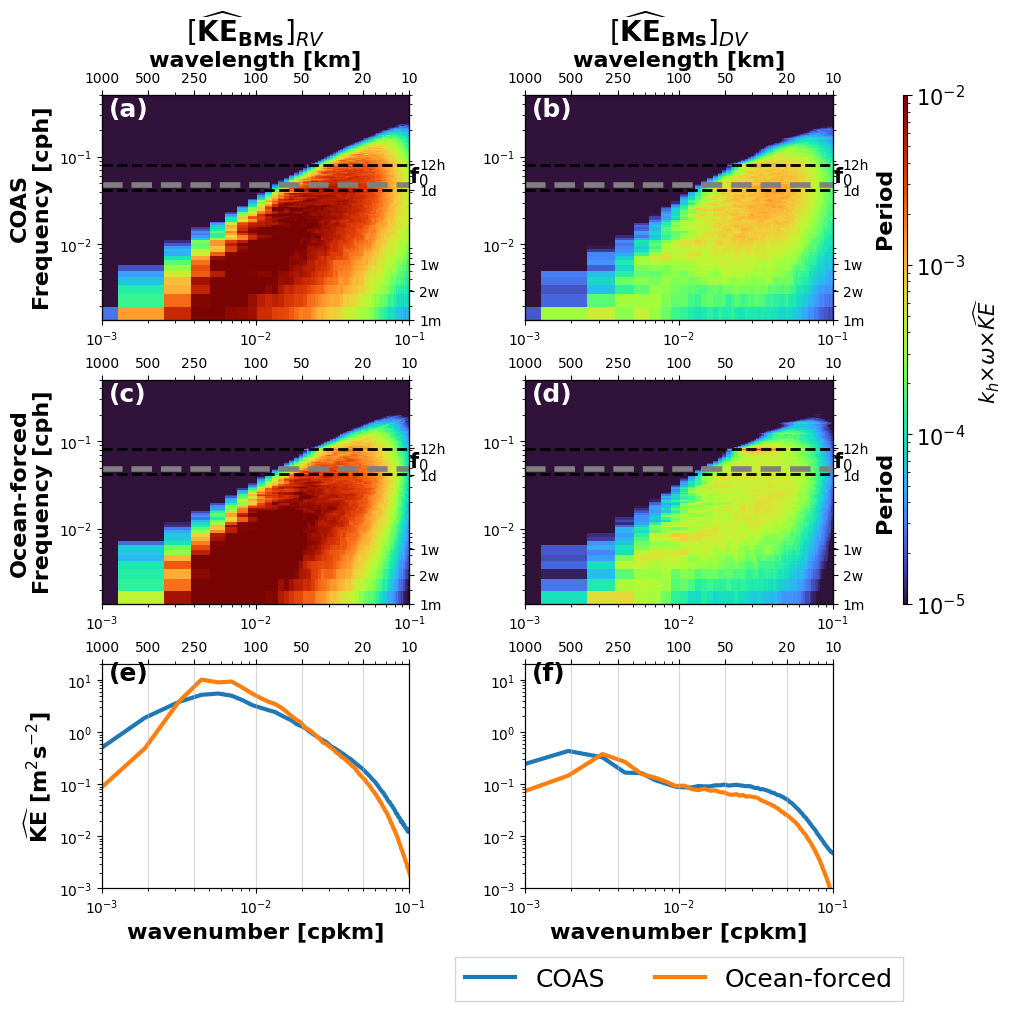

In [20]:
alphabet, num = string.ascii_lowercase, 0

fig, ax = plt.subplots(nrows=3,ncols=2,
                        figsize=(10,10),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)
az00=ax[0,0].pcolormesh(krr1, ktt1, RV_BMs_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az01=ax[0,1].pcolormesh(krr1, ktt1, DV_BMs_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az10=ax[1,0].pcolormesh(krr1, ktt1, RV_BMs_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az11=ax[1,1].pcolormesh(krr1, ktt1, DV_BMs_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

ax[2,0].loglog()
ax[2,0].plot(kr,np.trapz(RV_BMs_spec_coas,kt,axis=1), linewidth=3, color="#1f77b4")
ax[2,0].plot(kr,np.trapz(RV_BMs_spec_llc,kt,axis=1), linewidth=3, color="#ff7f0e", )
ax[2,1].loglog()
ax[2,1].plot(kr,np.trapz(DV_BMs_spec_coas,kt,axis=1), linewidth=3, color="#1f77b4", label="COAS")
ax[2,1].plot(kr,np.trapz(DV_BMs_spec_llc,kt,axis=1), linewidth=3, color="#ff7f0e",label="Ocean-forced")

ax[2,1].legend(loc='upper center', fontsize=18, ncol=2, fancybox=False, shadow=False, bbox_to_anchor=(0.5, -0.25))
 
for i in range(2):
    ax[2,i].set_xlim(1e-3,1e-1)
    ax[2,i].set_ylim(1e-3,1e2)
    #ax[2,i].plot([1/60, 1/60], [1e-3,1e2], '--', linewidth=4, color="gray") # f0 
    #ax[2,i].plot([1/30, 1/30], [1e-3,1e2], '--', linewidth=2, color="gray") # f0 

ax[0,0].set_ylabel("COAS\nFrequency [cph]", fontweight="bold", size=16)
ax[1,0].set_ylabel("Ocean-forced\nFrequency [cph]", fontweight="bold", size=16)
ax[0,0].set_title("[$\mathbf{\widehat{KE}_{BMs}}$]$_{RV}$",fontsize=20)
ax[0,1].set_title("[$\mathbf{\widehat{KE}_{BMs}}$]$_{DV}$",fontsize=20)
ax[2,0].set_ylabel("$\mathbf{\widehat{KE}}$ [m$^{2}$s$^{-2}$]", fontweight="bold", size=16)

cb1 = plt.colorbar(az11, ax=ax[:2,:], orientation='vertical', pad =0.001, aspect=140, fraction=0.03)       

cb1.ax.tick_params(labelsize=15)
cb1.set_label(label="$k_{h}$" r"$\times \omega$" r"$\times \widehat{KE}$", size=15)

#ax[2,2].legend(loc='upper center', fontsize=18, ncol=2, fancybox=False, shadow=False, bbox_to_anchor=(0.5, -0.25))

for i in range(2):
    ax[2,i].set_ylim(1e-3,2e1)
    ax1a = ax[2,i].twiny()
    ax1a.set_xlim(1e-3,1e-1)
    ax1a.set_xscale('log')
    ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
    ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10']) 
    ax1a.grid(alpha = 0.5)
    ax[2,i].set_xlabel("wavenumber [cpkm]", fontweight="bold", size=16)
    ax[0,i].text(1/900,1/3.5, "("+str(alphabet[i])+")", fontweight="bold", color="white", fontsize=18)
    ax[1,i].text(1/900,1/3.5, "("+str(alphabet[i+2])+")", fontweight="bold", color="white", fontsize=18)
    ax[2,i].text(1/900,1e1, "("+str(alphabet[i+4])+")", fontweight="bold", color="black", fontsize=18)
    #yrec1 = np.exp(-2*np.log(kr)-10+2)
    #yrec2 = np.exp(-3*np.log(kr)-14+2)
    #ax[2,i].plot(kr,yrec1, '--', linewidth=3, color="black")
    #ax[2,i].plot(kr,yrec2, '--', linewidth=3, color="gray")
   
for i in range(2):
    for k in range(2):
        ax[i,k].loglog()
        ax[i,k].set_xlim(1e-3,1e-1)
        ax[i,k].set_ylim(1/(24*30),1/2)
        ax1a = ax[i,k].twiny()
        ax1b = ax[i,k].twinx()
        if i==0:
            ax1a.set_xlabel("wavelength [km]", fontweight="bold", size=16)
        if k ==1:
            ax1b.set_ylabel("Period", fontweight="bold", size=16)
        ax1a.set_xlim(1e-3,1e-1)
        ax1a.set_ylim(1/(24*30),1/2)
        ax1b.set_xlim(1e-3,1e-1)
        ax1b.set_ylim(1/(24*30),1/2)
        ax1a.set_xscale('log')
        ax1a.set_yscale('log')
        ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
        ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10'])  
        ax1b.set_xscale('log')
        ax1b.set_yscale('log')
        ax1b.set_yticks([1/(24*30),1/(24*14),1/(24*7),1/24,1/12])
        ax1b.set_yticklabels(['1m','2w','1w','1d','12h'])
        ax[i,k].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
        ax[i,k].plot([1/1000, 1/10], [0.0805, 0.0805], '--', linewidth=2, color="black") # M2
        ax[i,k].plot([1/1000, 1/10], [0.0418, 0.0418], 'k--', linewidth=2) # K1
        ax[i,k].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)

plt.savefig("./KE_wk_spectrum_helmholtz_decomposition_RV_component_BMs_region_a.pdf", dpi=500)  

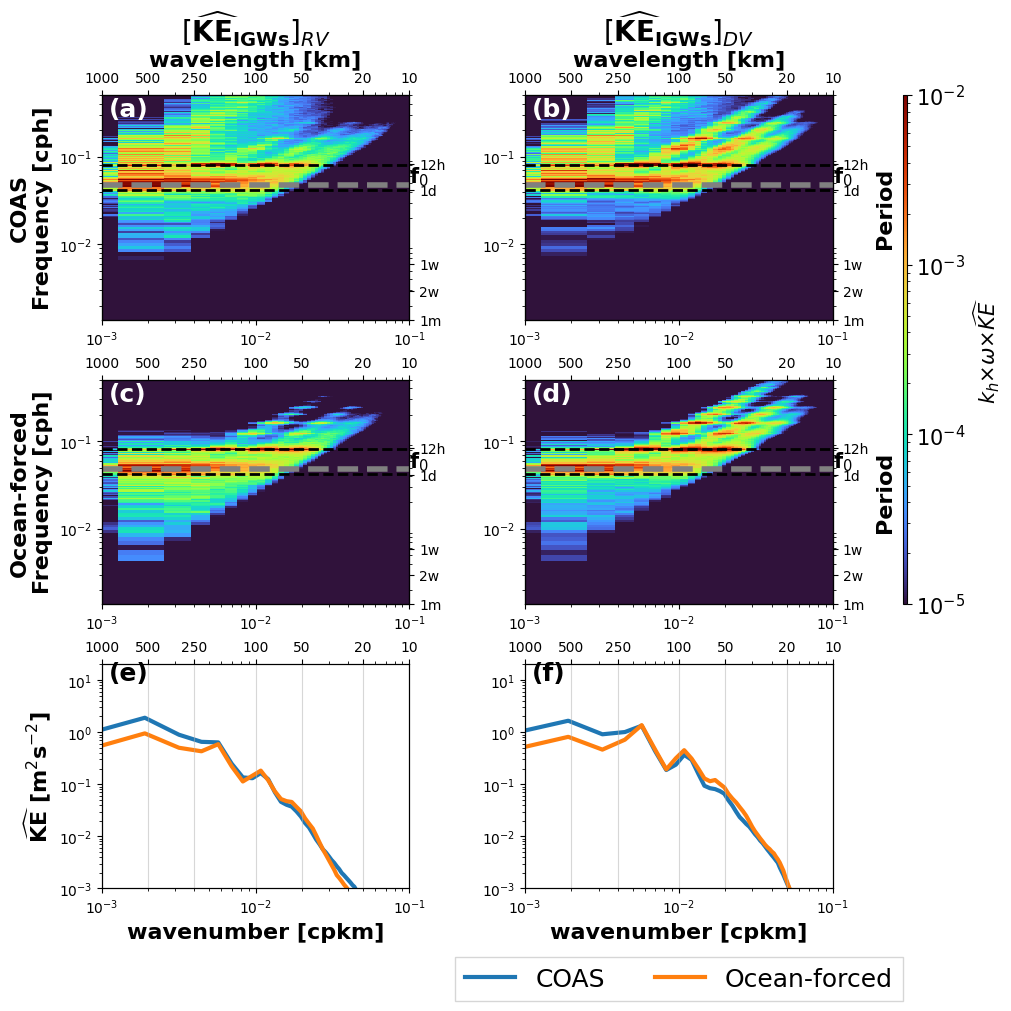

In [21]:
alphabet, num = string.ascii_lowercase, 0

fig, ax = plt.subplots(nrows=3,ncols=2,
                        figsize=(10,10),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)
az00=ax[0,0].pcolormesh(krr1, ktt1, RV_IGWs_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az01=ax[0,1].pcolormesh(krr1, ktt1, DV_IGWs_spec_coas.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az10=ax[1,0].pcolormesh(krr1, ktt1, RV_IGWs_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

az11=ax[1,1].pcolormesh(krr1, ktt1, DV_IGWs_spec_llc.T*krr1*ktt1,
                        norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="turbo", rasterized=True,)

ax[2,0].loglog()
ax[2,0].plot(kr,np.trapz(RV_IGWs_spec_coas,kt,axis=1), linewidth=3, color="#1f77b4")
ax[2,0].plot(kr,np.trapz(RV_IGWs_spec_llc,kt,axis=1), linewidth=3, color="#ff7f0e", )
ax[2,1].loglog()
ax[2,1].plot(kr,np.trapz(DV_IGWs_spec_coas,kt,axis=1), linewidth=3, color="#1f77b4", label="COAS")
ax[2,1].plot(kr,np.trapz(DV_IGWs_spec_llc,kt,axis=1), linewidth=3, color="#ff7f0e",label="Ocean-forced")

ax[2,1].legend(loc='upper center', fontsize=18, ncol=2, fancybox=False, shadow=False, bbox_to_anchor=(0.5, -0.25))
 
for i in range(2):
    ax[2,i].set_xlim(1e-3,1e-1)
    ax[2,i].set_ylim(1e-3,1e2)
    #ax[2,i].plot([1/60, 1/60], [1e-3,1e2], '--', linewidth=4, color="gray") # f0 
    #ax[2,i].plot([1/30, 1/30], [1e-3,1e2], '--', linewidth=2, color="gray") # f0 

ax[0,0].set_ylabel("COAS\nFrequency [cph]", fontweight="bold", size=16)
ax[1,0].set_ylabel("Ocean-forced\nFrequency [cph]", fontweight="bold", size=16)
ax[0,0].set_title("[$\mathbf{\widehat{KE}_{IGWs}}$]$_{RV}$",fontsize=20)
ax[0,1].set_title("[$\mathbf{\widehat{KE}_{IGWs}}$]$_{DV}$",fontsize=20)
ax[2,0].set_ylabel("$\mathbf{\widehat{KE}}$ [m$^{2}$s$^{-2}$]", fontweight="bold", size=16)

cb1 = plt.colorbar(az11, ax=ax[:2,:], orientation='vertical', pad =0.001, aspect=140, fraction=0.03)       

cb1.ax.tick_params(labelsize=15)
cb1.set_label(label="$k_{h}$" r"$\times \omega$" r"$\times \widehat{KE}$", size=15)

#ax[2,2].legend(loc='upper center', fontsize=18, ncol=2, fancybox=False, shadow=False, bbox_to_anchor=(0.5, -0.25))

for i in range(2):
    ax[2,i].set_ylim(1e-3,2e1)
    ax1a = ax[2,i].twiny()
    ax1a.set_xlim(1e-3,1e-1)
    ax1a.set_xscale('log')
    ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
    ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10']) 
    ax1a.grid(alpha = 0.5)
    ax[2,i].set_xlabel("wavenumber [cpkm]", fontweight="bold", size=16)
    ax[0,i].text(1/900,1/3.5, "("+str(alphabet[i])+")", fontweight="bold", color="white", fontsize=18)
    ax[1,i].text(1/900,1/3.5, "("+str(alphabet[i+2])+")", fontweight="bold", color="white", fontsize=18)
    ax[2,i].text(1/900,1e1, "("+str(alphabet[i+4])+")", fontweight="bold", color="black", fontsize=18)
    #yrec1 = np.exp(-2*np.log(kr)-10+2)
    #yrec2 = np.exp(-3*np.log(kr)-14+2)
    #ax[2,i].plot(kr,yrec1, '--', linewidth=3, color="black")
    #ax[2,i].plot(kr,yrec2, '--', linewidth=3, color="gray")
   
for i in range(2):
    for k in range(2):
        ax[i,k].loglog()
        ax[i,k].set_xlim(1e-3,1e-1)
        ax[i,k].set_ylim(1/(24*30),1/2)
        ax1a = ax[i,k].twiny()
        ax1b = ax[i,k].twinx()
        if i==0:
            ax1a.set_xlabel("wavelength [km]", fontweight="bold", size=16)
        if k ==1:
            ax1b.set_ylabel("Period", fontweight="bold", size=16)
        ax1a.set_xlim(1e-3,1e-1)
        ax1a.set_ylim(1/(24*30),1/2)
        ax1b.set_xlim(1e-3,1e-1)
        ax1b.set_ylim(1/(24*30),1/2)
        ax1a.set_xscale('log')
        ax1a.set_yscale('log')
        ax1a.set_xticks([1/1000,1/500,1/250,1/100,1/50,1/20,1/10])
        ax1a.set_xticklabels(['1000','500','250','100','50',"20",'10'])  
        ax1b.set_xscale('log')
        ax1b.set_yscale('log')
        ax1b.set_yticks([1/(24*30),1/(24*14),1/(24*7),1/24,1/12])
        ax1b.set_yticklabels(['1m','2w','1w','1d','12h'])
        ax[i,k].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
        ax[i,k].plot([1/1000, 1/10], [0.0805, 0.0805], '--', linewidth=2, color="black") # M2
        ax[i,k].plot([1/1000, 1/10], [0.0418, 0.0418], 'k--', linewidth=2) # K1
        ax[i,k].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)

plt.savefig("./KE_wk_spectrum_helmholtz_decomposition_DV_component_BMs_region_a.pdf", dpi=500)  

In [106]:
kr, kt, RV_IGWs_spec_llc, DV_IGWs_spec_llc, RVDV_IGWs_spec_llc = computing_RV_DV_spectrum(u_igw_llc,
                                                                                       v_igw_llc,
                                                                                       dx, dy, dt
                                                                                      )
kr, kt, RV_IGWs_spec_coas, DV_IGWs_spec_coas, RVDV_IGWs_spec_coas = computing_RV_DV_spectrum(u_igw_coas,
                                                                                          v_igw_coas,
                                                                                          dx, dy, dt
                                                                                         )

1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...
1) detrending ...
2) windowing ...
3) fft in 3D...
5) computing gradients ...


In [10]:
import numpy as np
import xarray as xr
from scipy import signal
import numpy.fft as fft

def time_filtering(u, v, dx, dy, dt, f0=1/24, order=10):
    print("Applying the dynamical filter...")
    
    nx, ny, nt = u.shape
    kx, ky, omega = fft.fftfreq(nx, dx), fft.fftfreq(ny, dy), fft.fftfreq(nt, dt)
    dkx, dky = kx[1] - kx[0], ky[1] - ky[0]
    dkr = np.sqrt(dkx**2 + dky**2)
    kh = np.sqrt(kx[:, None]**2 + ky[None, :]**2)
    kh[kh == kh.min()] = dkr / 2

    omega_c = kh*0+f0

    # Create spectral mask
    mask = 1 / (1 + ((omega[None, None, :] / omega_c[:, :, None])**(2 * order)))

    # Remove linear trend
    u = signal.detrend(u, axis=2, type="linear")
    v = signal.detrend(v, axis=2, type="linear")

    # Apply filter in Fourier domain
    u_bm = fft.ifftn(fft.fftn(u, axes=(0, 1, 2)) * mask, axes=(0, 1, 2)).real
    v_bm = fft.ifftn(fft.fftn(v, axes=(0, 1, 2)) * mask, axes=(0, 1, 2)).real

    return u_bm, v_bm

In [11]:
u_filt_coas, v_filt_coas = time_filtering(dc.U.values,
                                          dc.V.values,
                                          dx, dy, dt,
                                          f0=1/24, 
                                          order=6
                                         )

u_filt_llc, v_filt_llc = time_filtering(du.U.values,
                                        du.V.values,
                                        dx, dy, dt,
                                        f0=1/24,
                                        order=6
                                       )

Applying the dynamical filter...
Applying the dynamical filter...


In [12]:
u_bm_coas_filt, v_bm_coas_filt =time_filtering(u_bm_coas,
                                               v_bm_coas,
                                               dx, dy, dt,
                                               f0=1/24,
                                               order=6
                                              ) 

u_igw_coas_filt, v_igw_coas_filt =time_filtering(u_igw_coas,
                                                 v_igw_coas,
                                                 dx, dy, dt,
                                                 f0=1/24,
                                                 order=6
                                                ) 

Applying the dynamical filter...
Applying the dynamical filter...


In [13]:
u_bm_llc_filt, v_bm_llc_filt =time_filtering(u_bm_llc,
                                             v_bm_llc,
                                             dx, dy, dt,
                                             f0=1/24,
                                             order=6
                                            ) 

u_igw_llc_filt, v_igw_llc_filt =time_filtering(u_igw_llc,
                                               v_igw_llc,
                                               dx, dy, dt,
                                               f0=1/24,
                                               order=6
                                              ) 

Applying the dynamical filter...
Applying the dynamical filter...


In [14]:
# Create an xarray Dataset
ds = xr.Dataset(
    {
        "u_tot": (["longitude", "latitude", "time"], u_filt_coas),
        "v_tot": (["longitude", "latitude", "time"], v_filt_coas),
        "u_BMs": (["longitude", "latitude", "time"], u_bm_coas_filt),
        "v_BMs": (["longitude", "latitude", "time"], v_bm_coas_filt),
        "u_IGWs": (["longitude", "latitude", "time"], u_igw_coas_filt),
        "v_IGWs": (["longitude", "latitude", "time"], v_igw_coas_filt),
    },
    coords={
        "latitude": dc.latitude,
        "longitude": dc.longitude,
        "time": dc.time
    }
)

ds['u_tot'] = ds['u_tot'].fillna(-32767)
ds['u_tot'].encoding['_FillValue'] = -32767
ds['v_tot'] = ds['v_tot'].fillna(-32767)
ds['v_tot'].encoding['_FillValue'] = -32767

ds['u_BMs'] = ds['u_BMs'].fillna(-32767)
ds['u_BMs'].encoding['_FillValue'] = -32767
ds['v_BMs'] = ds['v_BMs'].fillna(-32767)
ds['v_BMs'].encoding['_FillValue'] = -32767

ds['u_IGWs'] = ds['u_IGWs'].fillna(-32767)
ds['u_IGWs'].encoding['_FillValue'] = -32767
ds['v_IGWs'] = ds['v_IGWs'].fillna(-32767)
ds['v_IGWs'].encoding['_FillValue'] = -32767

# Save the dataset to a NetCDF file (optional)
netcdf_path = "./current_dynamical_filter_coas_time_filter.nc"
ds.transpose("time", "latitude", "longitude").to_netcdf(netcdf_path)

In [15]:
# Create an xarray Dataset
ds = xr.Dataset(
    {
        "u_tot": (["longitude", "latitude", "time"], u_filt_llc),
        "v_tot": (["longitude", "latitude", "time"], v_filt_llc),
        "u_BMs": (["longitude", "latitude", "time"], u_bm_llc_filt),
        "v_BMs": (["longitude", "latitude", "time"], v_bm_llc_filt),
        "u_IGWs": (["longitude", "latitude", "time"], u_igw_llc_filt),
        "v_IGWs": (["longitude", "latitude", "time"], v_igw_llc_filt),
    },
    coords={
        "latitude": dc.latitude,
        "longitude": dc.longitude,
        "time": dc.time
    }
)

ds['u_tot'] = ds['u_tot'].fillna(-32767)
ds['u_tot'].encoding['_FillValue'] = -32767
ds['v_tot'] = ds['v_tot'].fillna(-32767)
ds['v_tot'].encoding['_FillValue'] = -32767

ds['u_BMs'] = ds['u_BMs'].fillna(-32767)
ds['u_BMs'].encoding['_FillValue'] = -32767
ds['v_BMs'] = ds['v_BMs'].fillna(-32767)
ds['v_BMs'].encoding['_FillValue'] = -32767

ds['u_IGWs'] = ds['u_IGWs'].fillna(-32767)
ds['u_IGWs'].encoding['_FillValue'] = -32767
ds['v_IGWs'] = ds['v_IGWs'].fillna(-32767)
ds['v_IGWs'].encoding['_FillValue'] = -32767

# Save the dataset to a NetCDF file (optional)
netcdf_path = "./current_dynamical_filter_ocean_forced_time_filter.nc"
ds.transpose("time", "latitude", "longitude").to_netcdf(netcdf_path)

In [ ]:
kr, kt, ke_spec_llc_filt = computing_KE_spectrum(u_bm_coas_filt,
                                            v_bm_coas_filt,
                                            dx, dy, dt
                                           )
kr, kt, ke_spec_coas_filt = computing_KE_spectrum(u_bm_llc_filt,
                                             u_bm_llc_filt,
                                             dx, dy, dt
                                            )

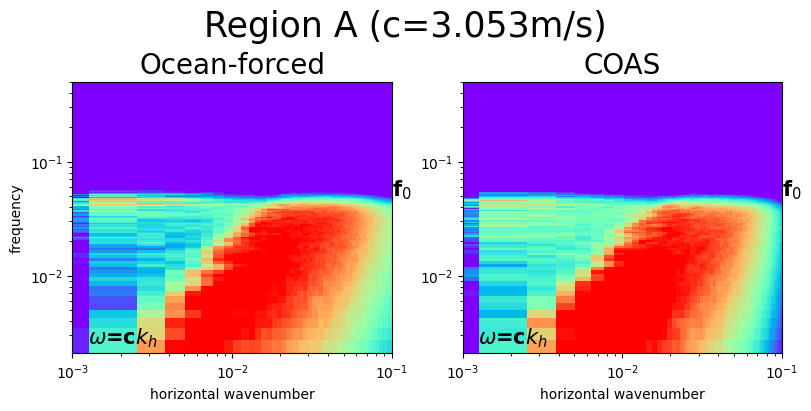

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2,
                        figsize=(8,4),constrained_layout=True)

krr1, ktt1 = np.meshgrid(kr, kt)

ax[0].pcolormesh(krr1, ktt1, ke_spec_llc_filt.T*krr1*ktt1,
               norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

ax[1].pcolormesh(krr1, ktt1, ke_spec_coas_filt.T*krr1*ktt1,
               norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap="rainbow", rasterized=True,)

fig.suptitle("Region A (c="+str(c)+"m/s)", fontsize=25)
ax[0].set_title("Ocean-forced", fontsize=20)
ax[1].set_title("COAS", fontsize=20)
ax[0].set_ylabel("frequency", fontsize=10)

for i in range(2):
    ax[i].loglog()
    #for j in range(n_mode):
    #    ax[i].plot(kr,omega[j,:],":", color="white", linewidth=2)
    #ax[i].plot(kr,omega0,":",color="gray", linewidth=4)
    ax[i].set_xlim(1e-3,1e-1)
    ax[i].set_ylim(1/(24*20),1/2)
    #ax[i].plot([1/1000, 1/10], [f0, f0], '--', linewidth=4, color="gray") # f0 
    ax[i].text(1/10,1/20, "f$_{0}$", fontweight="bold", color="black", fontsize=15)
    ax[i].text(1/800,1/400, "$\omega$=c$k_{h}$", fontweight="bold", color="black", fontsize=15)
    ax[i].set_xlabel("horizontal wavenumber", fontsize=10)

#plt.savefig("./KE_wk_spectrum_region_a.pdf", dpi=500)                 